In [ ]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install dowhy
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 29 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

In [ ]:
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets
import numpy as np
import pygraphviz
from IPython.display import Image,display
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('Merged KPIS.csv')
df.head()

Saving Merged KPIS.csv to Merged KPIS.csv


,Municipality,Residential Property Tax,Commercial Property Tax,Residential Units,Community
0,Amherst,77297319,31536980,20,West Amherst
1,New Glasgow,75896997,31024284,15,Downtown New Glasgow
2,Yarmouth,73819220,30535968,10,South Yarmouth
3,Antigonish,71283730,30654728,18,St. Andrews
4,Port Hawkesbury,69563851,30320283,25,Granville Street


In [ ]:
df_clean = df.rename(columns={
    'Municipality': 'Municipality',
    'Residential Property Tax': 'Res_Property_Tax',
    'Commercial Property Tax': 'Com_Property_Tax',
    'Residential Units': 'Res_Units',
    'Community': 'Community'
    })
kpi_data = df_clean[['Municipality','Res_Property_Tax','Com_Property_Tax','Res_Units','Community']]


In [ ]:
full_kpi_data = kpi_data.copy()

In [ ]:
correlation_matrix = kpi_data.select_dtypes(include='number').corr()


In [ ]:
kpi_data.head()

,Municipality,Res_Property_Tax,Com_Property_Tax,Res_Units,Community
0,Amherst,77297319,31536980,20,West Amherst
1,New Glasgow,75896997,31024284,15,Downtown New Glasgow
2,Yarmouth,73819220,30535968,10,South Yarmouth
3,Antigonish,71283730,30654728,18,St. Andrews
4,Port Hawkesbury,69563851,30320283,25,Granville Street


In [ ]:
kpi_data.select_dtypes(include= 'number')

,Res_Property_Tax,Com_Property_Tax,Res_Units
0,77297319,31536980,20
1,75896997,31024284,15
2,73819220,30535968,10
3,71283730,30654728,18
4,69563851,30320283,25


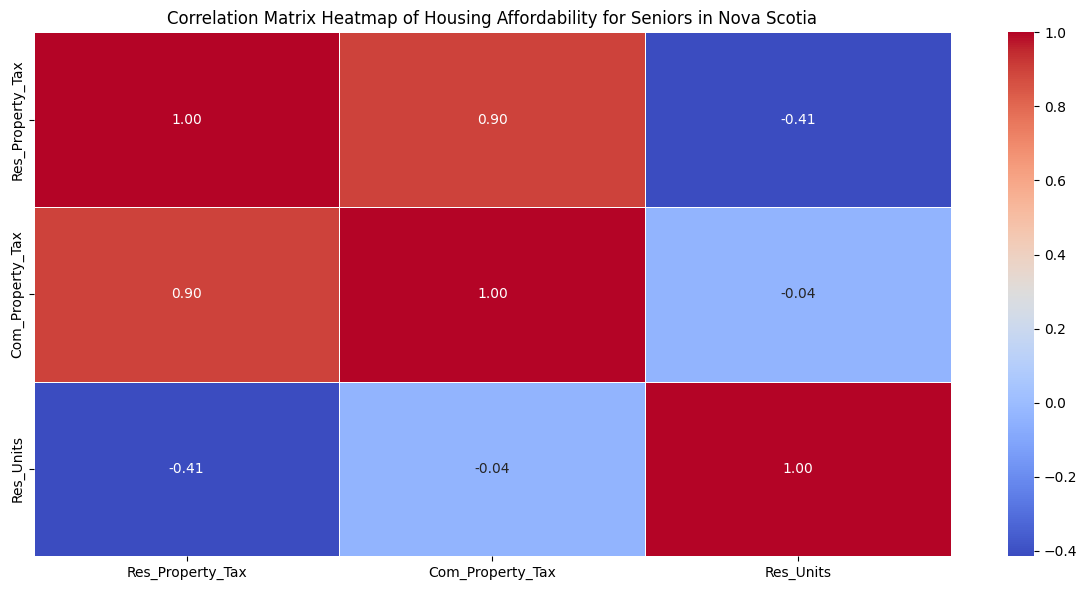

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap of Housing Affordability for Seniors in Nova Scotia')
plt.tight_layout()
plt.show()

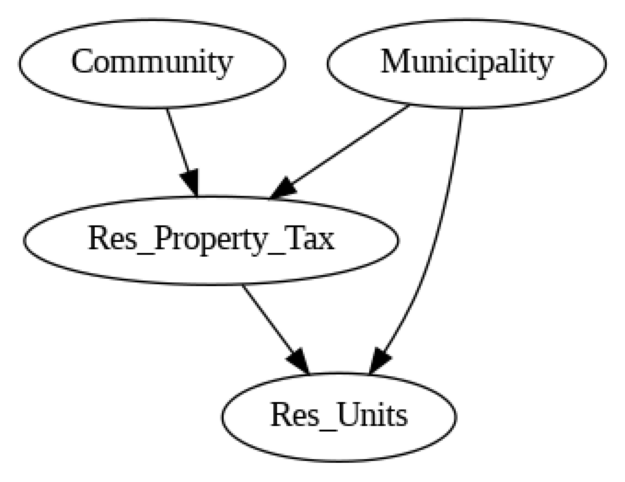

In [ ]:
graph = """digraph {
   Municipality -> Res_Property_Tax;
   Municipality -> Com_Property_Tax;
   Res_Property_Tax -> Res_Units;
   Com_Property_Tax -> Res_Units;
   Community -> Res_Units;
}"""

model = CausalModel(
    data=kpi_data,
    treatment="Res_Property_Tax",
    outcome="Res_Units",
    common_causes=["Municipality"],
    instruments=["Community"])

model.view_model()

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                    
───────────────────(E[Res_Units|Municipality])
d[Res_Property_Tax]                           
Estimand assumption 1, Unconfoundedness: If U→{Res_Property_Tax} and U→Res_Units then P(Res_Units|Res_Property_Tax,Municipality,U) = P(Res_Units|Res_Property_Tax,Municipality)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                          -1⎤
 ⎢     d                  ⎛     d                          ⎞  ⎥
E⎢────────────(Res_Units)⋅⎜────────────([Res_Property_Tax])⎟  ⎥
 ⎣d[Community]            ⎝d[Community]                    ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Res_Units then ¬(U →→{Community})
Estimand assumption 2, Exclusion: If we remove {Community}→{Res_Property_Tax}, then ¬({Community}→Res_Units)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
causal_effect = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(f"Estimated Causal Effect of Ad Spend on Sales: {causal_effect}")

Estimated Causal Effect of Ad Spend on Sales: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                    
───────────────────(E[Res_Units|Municipality])
d[Res_Property_Tax]                           
Estimand assumption 1, Unconfoundedness: If U→{Res_Property_Tax} and U→Res_Units then P(Res_Units|Res_Property_Tax,Municipality,U) = P(Res_Units|Res_Property_Tax,Municipality)

## Realized estimand
b: Res_Units~Res_Property_Tax+Municipality
Target units: ate

## Estimate
Mean value: 2.5655112856348694e-07



/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as pos

In [ ]:
refute = model.refute_estimate(identified_estimand, causal_effect, method_name="random_common_cause")
print(refute)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as pos

Refute: Add a random common cause
Estimated effect:2.5655112856348694e-07
New effect:2.4537120902572934e-07
p value:0.54



/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - se